# 04 — Nutritional Gap Deep Dives

**Objective:** For the top-opportunity categories identified in notebook 03, drill into:
1. Nutri-Score distributions — what does "96% CDE" actually look like?
2. Nutrient profiles — which nutrients make each category unhealthy?
3. Reformulation paths — what changes would shift a typical product from D→B?
4. PL vs national brand quality — are PL products worse, same, or better?
5. Cross-country variation — does the gap differ between France, Germany, Spain?

In [1]:
import os, sys
# Ensure we're at project root for relative paths
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print('Working directory:', os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.analysis.nutritional_gaps import compute_nutritional_landscape, compute_nutrient_stats
from src.analysis.reformulation import analyse_reformulation

sns.set_theme(style='whitegrid', palette='colorblind')
os.makedirs('results', exist_ok=True)
print('Imports OK')

Working directory: /Users/joshua/PycharmProjects/PortfolioProjectIdeas/PrivateLabelOpportunities


Imports OK


In [2]:
# Load datasets
df = pd.read_parquet('data/processed/off_eu_clean.parquet')
cat_summary = pd.read_parquet('data/processed/category_summary.parquet')

# Filter to products with Nutri-Score + category
has_score = df['nutriscore_grade'].isin(['a', 'b', 'c', 'd', 'e'])
has_cat = df['category_l1'].notna() & (df['category_l1'] != 'Unknown')
df_scored = df[has_score & has_cat].copy()
print(f'Products with Nutri-Score + category: {len(df_scored):,}')

# Top 10 categories by nutritional gap
top10 = cat_summary.nlargest(10, 'nutritional_gap')
top10_names = top10['category_l1'].tolist()
print(f'\nTop 10 gap categories: {top10_names}')
top10[['category_l1', 'pct_grade_cde', 'pl_penetration_ab', 'nutritional_gap', 'n_products']].round(3)

Products with Nutri-Score + category: 837,912

Top 10 gap categories: ['Taralli', 'Breakfast', 'Fish And Meat And Eggs', 'Festive Foods', 'Snacks', 'Meat Products', 'Crepes And Galettes', 'Desserts', 'Fats & Oils', 'Spreads']


,category_l1,pct_grade_cde,pl_penetration_ab,nutritional_gap,n_products
0,Taralli,1.000,0.000,1.000,101
1,Breakfast,0.984,0.050,0.935,7674
2,Fish And Meat And Eggs,0.968,0.043,0.926,2866
3,Festive Foods,0.960,0.077,0.886,322
4,Snacks,0.963,0.087,0.879,119433
5,Meat Products,0.855,0.000,0.855,159
6,Crepes And Galettes,0.937,0.100,0.843,1269
7,Desserts,0.951,0.119,0.839,15079
8,Fats & Oils,0.865,0.035,0.834,837
9,Spreads,0.951,0.149,0.810,2063


## 1. Nutri-Score Distributions for Top 10 Categories

Stacked bar charts showing the full A-B-C-D-E breakdown. Categories are sorted by % CDE (worst first).

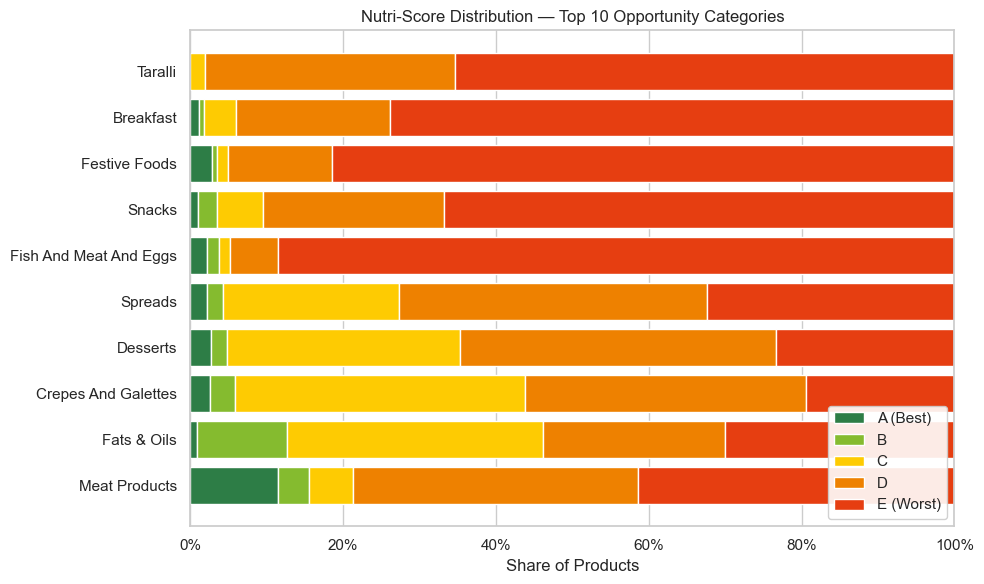

Saved: results/top10_nutriscore_distributions.png


In [3]:
# Compute grade distributions for top 10
df_top = df_scored[df_scored['category_l1'].isin(top10_names)].copy()

grade_counts = df_top.groupby(['category_l1', 'nutriscore_grade']).size().unstack(fill_value=0)
grade_pct = grade_counts.div(grade_counts.sum(axis=1), axis=0)
for g in 'abcde':
    if g not in grade_pct.columns:
        grade_pct[g] = 0.0
grade_pct = grade_pct[['a', 'b', 'c', 'd', 'e']]

# Sort by %CDE (worst first)
grade_pct['cde'] = grade_pct[['c', 'd', 'e']].sum(axis=1)
grade_pct = grade_pct.sort_values('cde', ascending=True)
grade_pct = grade_pct.drop(columns='cde')

# Plot stacked horizontal bars
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'a': '#2d7d46', 'b': '#85bb2f', 'c': '#fecb02', 'd': '#ee8100', 'e': '#e63e11'}
labels = {'a': 'A (Best)', 'b': 'B', 'c': 'C', 'd': 'D', 'e': 'E (Worst)'}

left = np.zeros(len(grade_pct))
for grade in ['a', 'b', 'c', 'd', 'e']:
    vals = grade_pct[grade].values
    ax.barh(grade_pct.index, vals, left=left, color=colors[grade], label=labels[grade])
    left += vals

ax.set_xlabel('Share of Products')
ax.set_title('Nutri-Score Distribution — Top 10 Opportunity Categories')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.legend(loc='lower right', framealpha=0.9)
ax.set_xlim(0, 1)
plt.tight_layout()
plt.savefig('results/top10_nutriscore_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/top10_nutriscore_distributions.png')

## 2. Nutrient Heatmap — What Makes Each Category Unhealthy?

For each top-10 category, show median values of the key Nutri-Score nutrients (sugars, sat fat, salt, fibre, protein, energy). Normalised across categories so high = bad for negative nutrients.

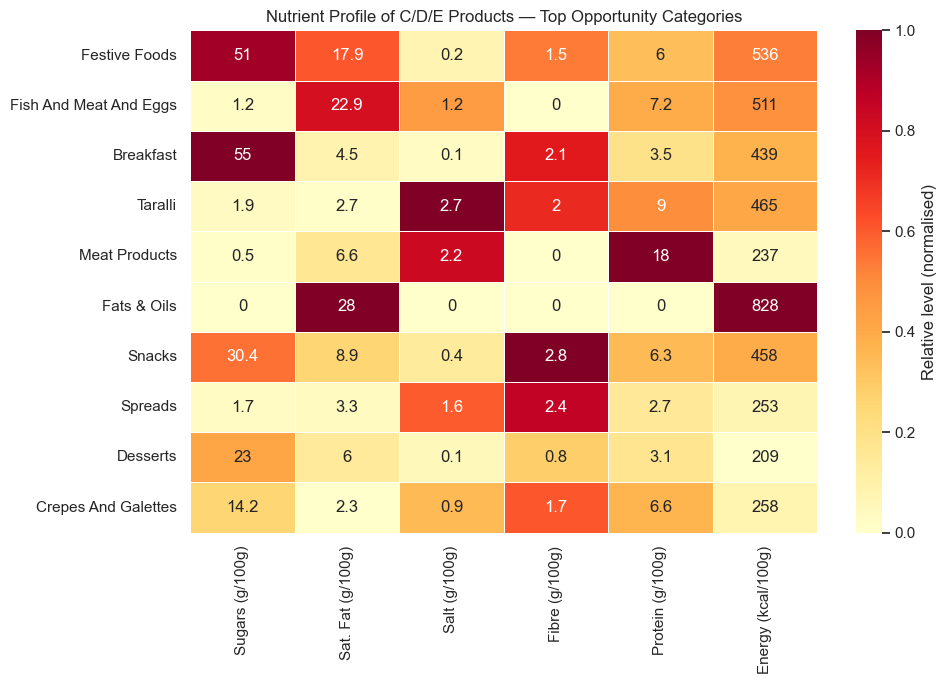

Saved: results/nutrient_heatmap_top10.png


In [4]:
# Compute median nutrients for CDE products in top 10 categories
nutrient_cols = ['sugars_100g', 'saturated_fat_100g', 'salt_100g',
                 'fiber_100g', 'proteins_100g', 'energy_kcal_100g']
available_nutr = [c for c in nutrient_cols if c in df_top.columns]

cde_products = df_top[df_top['nutriscore_grade'].isin(['c', 'd', 'e'])]
nutrient_medians = cde_products.groupby('category_l1')[available_nutr].median()

# Normalise 0-1 across categories for heatmap
nutrient_norm = (nutrient_medians - nutrient_medians.min()) / (nutrient_medians.max() - nutrient_medians.min() + 1e-9)

# Rename for display
display_names = {
    'sugars_100g': 'Sugars (g/100g)',
    'saturated_fat_100g': 'Sat. Fat (g/100g)',
    'salt_100g': 'Salt (g/100g)',
    'fiber_100g': 'Fibre (g/100g)',
    'proteins_100g': 'Protein (g/100g)',
    'energy_kcal_100g': 'Energy (kcal/100g)',
}
nutrient_norm = nutrient_norm.rename(columns=display_names)

# Sort by total negative nutrient burden
neg_cols = [display_names[c] for c in ['sugars_100g', 'saturated_fat_100g', 'salt_100g'] if c in display_names]
neg_sum = nutrient_norm[neg_cols].sum(axis=1)
nutrient_norm = nutrient_norm.loc[neg_sum.sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(nutrient_norm, annot=nutrient_medians.rename(columns=display_names).loc[nutrient_norm.index].round(1),
            fmt='g', cmap='YlOrRd', linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Relative level (normalised)'})
ax.set_title('Nutrient Profile of C/D/E Products — Top Opportunity Categories')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('results/nutrient_heatmap_top10.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/nutrient_heatmap_top10.png')

## 3. Reformulation Feasibility

For each top category, what specific nutrient reductions would shift a typical C/D/E product to a B grade?

Uses binary search over the Nutri-Score algorithm to find minimum changes.

In [5]:
# Run reformulation analysis on top 10 categories
reform_results = analyse_reformulation(
    df_top,
    category_col='category_l1',
    target_grade='b',
)

print(f'Reformulation paths found for {len(reform_results)} categories:\n')

reform_rows = []
for category, targets in reform_results.items():
    print(f'--- {category} ---')
    for t in targets:
        change_desc = f'{t.current_median}g → {t.target_value}g ({t.reduction_pct:.0f}% reduction)'
        print(f'  {t.nutrient}: {change_desc}')
        reform_rows.append({
            'category': category,
            'nutrient': t.nutrient,
            'current_median': t.current_median,
            'target_value': t.target_value,
            'reduction_pct': t.reduction_pct,
        })
    print()

if reform_rows:
    df_reform = pd.DataFrame(reform_rows)
    print('\nReformulation summary table:')
    display(df_reform)

Reformulation paths found for 7 categories:

--- Breakfast ---
  sugars_g: 55.0g → 9.0g (84% reduction)

--- Crepes And Galettes ---
  sugars_g: 14.2g → 9.0g (37% reduction)
  saturated_fat_g: 2.3g → 1.0g (56% reduction)
  salt_g: 0.9g → 0.7g (27% reduction)

--- Fats & Oils ---
  saturated_fat_g: 28.0g → 1.0g (96% reduction)

--- Fish And Meat And Eggs ---
  saturated_fat_g: 22.9g → 1.0g (96% reduction)

--- Meat Products ---
  salt_g: 2.2g → 0.4g (80% reduction)

--- Spreads ---
  salt_g: 1.6g → 0.7g (58% reduction)

--- Taralli ---
  salt_g: 2.7g → 1.6g (41% reduction)


Reformulation summary table:


,category,nutrient,current_median,target_value,reduction_pct
0,Breakfast,sugars_g,55.0,9.0,83.6
1,Crepes And Galettes,sugars_g,14.2,9.0,36.6
2,Crepes And Galettes,saturated_fat_g,2.3,1.0,56.5
3,Crepes And Galettes,salt_g,0.9,0.7,27.4
4,Fats & Oils,saturated_fat_g,28.0,1.0,96.4
5,Fish And Meat And Eggs,saturated_fat_g,22.9,1.0,95.6
6,Meat Products,salt_g,2.2,0.4,79.5
7,Spreads,salt_g,1.6,0.7,57.8
8,Taralli,salt_g,2.7,1.6,40.8


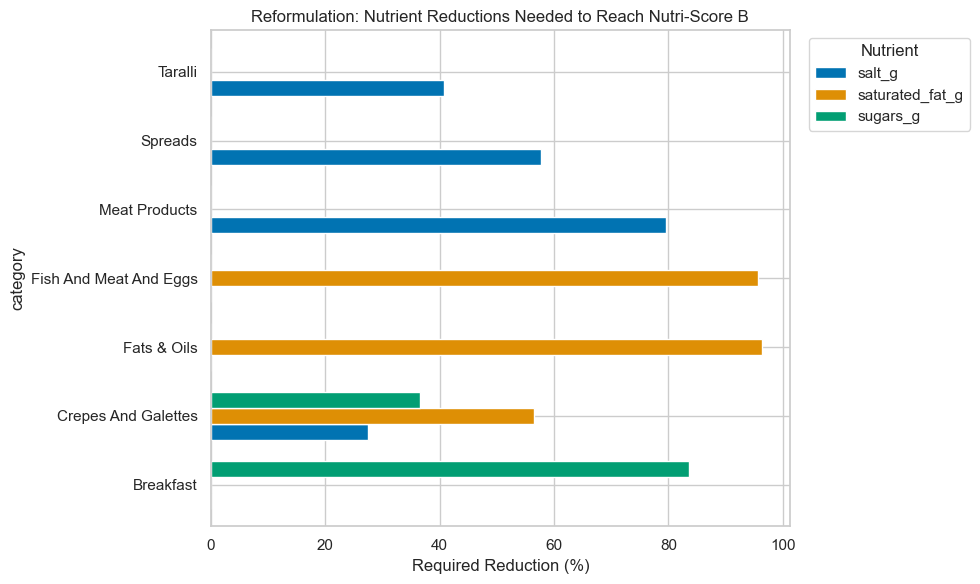

Saved: results/reformulation_reductions.png


In [6]:
# Visualise reformulation: grouped bar chart of required reductions
if reform_rows:
    df_reform = pd.DataFrame(reform_rows)
    
    # Pivot for grouped bar chart
    pivot = df_reform.pivot_table(index='category', columns='nutrient', values='reduction_pct', aggfunc='first')
    pivot = pivot.fillna(0)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot.plot(kind='barh', ax=ax, width=0.7)
    ax.set_xlabel('Required Reduction (%)')
    ax.set_title('Reformulation: Nutrient Reductions Needed to Reach Nutri-Score B')
    ax.legend(title='Nutrient', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('results/reformulation_reductions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: results/reformulation_reductions.png')
else:
    print('No reformulation paths found (all categories may already be at target grade)')

## 4. Private Label vs National Brand — Nutritional Quality

Are existing PL products nutritionally better or worse than national brands in the same category? If PL is already healthier, the gap is smaller. If PL is *worse*, the opportunity is even bigger.

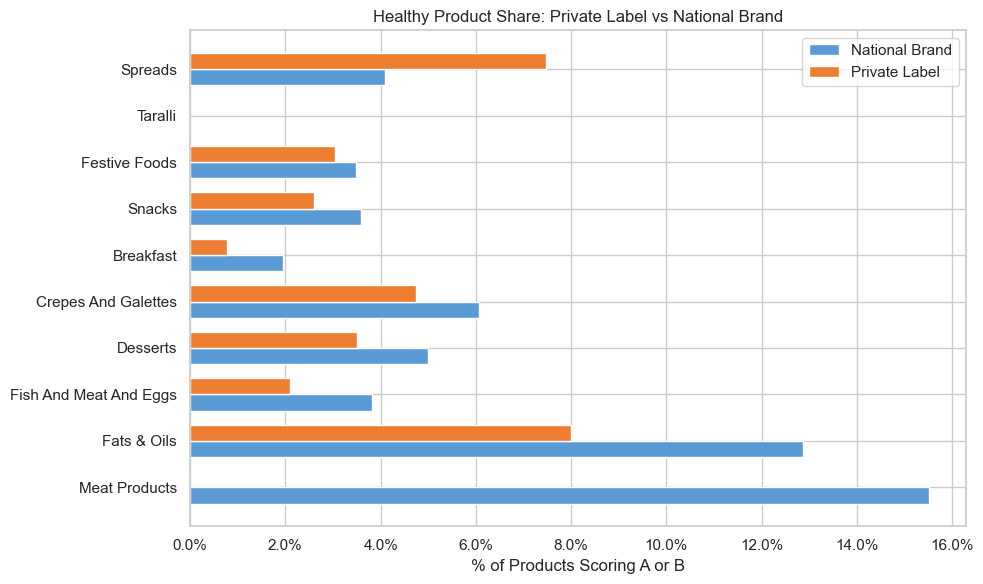

Saved: results/pl_vs_brand_health.png

PL Advantage (positive = PL healthier):


,National Brand % A/B,Private Label % A/B,PL Advantage
category_l1,,,
Meat Products,0.155,0.000,-0.155
Fats & Oils,0.129,0.080,-0.049
Fish And Meat And Eggs,0.038,0.021,-0.017
Desserts,0.050,0.035,-0.015
Crepes And Galettes,0.061,0.047,-0.013
Breakfast,0.020,0.008,-0.012
Snacks,0.036,0.026,-0.010
Festive Foods,0.035,0.030,-0.005
Taralli,0.000,0.000,0.000


In [7]:
# PL vs Brand: compare % A/B for each top category
# Derive is_pl from pl_retailer column
if 'pl_retailer' in df_top.columns:
    df_top['is_pl'] = df_top['pl_retailer'].notna() & (df_top['pl_retailer'] != '')

if 'is_pl' in df_top.columns:
    df_top['is_healthy'] = df_top['nutriscore_grade'].isin(['a', 'b'])
    
    pl_health = df_top.groupby(['category_l1', 'is_pl'])['is_healthy'].mean().unstack(fill_value=0)
    pl_health.columns = ['National Brand % A/B', 'Private Label % A/B']
    pl_health = pl_health.loc[pl_health.index.isin(top10_names)]
    pl_health['PL Advantage'] = pl_health['Private Label % A/B'] - pl_health['National Brand % A/B']
    pl_health = pl_health.sort_values('PL Advantage')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(pl_health))
    w = 0.35
    ax.barh(x - w/2, pl_health['National Brand % A/B'], w, label='National Brand', color='#5b9bd5')
    ax.barh(x + w/2, pl_health['Private Label % A/B'], w, label='Private Label', color='#ed7d31')
    ax.set_yticks(x)
    ax.set_yticklabels(pl_health.index)
    ax.set_xlabel('% of Products Scoring A or B')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_title('Healthy Product Share: Private Label vs National Brand')
    ax.legend()
    plt.tight_layout()
    plt.savefig('results/pl_vs_brand_health.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: results/pl_vs_brand_health.png')
    
    print('\nPL Advantage (positive = PL healthier):')
    display(pl_health.round(3))
else:
    print('Neither is_pl nor pl_retailer column found — PL flagging may not have run.')

## 5. Cross-Country Variation

Does the nutritional gap differ by country? A category that's 95% CDE in Spain but only 70% in France suggests country-specific strategies.

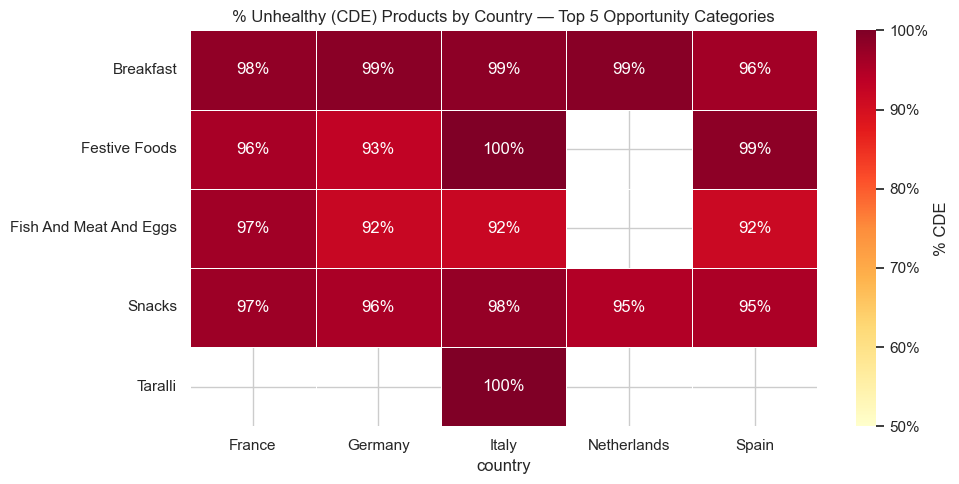

Saved: results/cross_country_cde.png

Sample sizes per cell:


country,France,Germany,Italy,Netherlands,Spain
category,,,,,
Breakfast,5496,1209,1234,224,838
Festive Foods,402,43,66,0,69
Fish And Meat And Eggs,3336,38,37,0,119
Snacks,84641,17260,17052,3349,16944
Taralli,0,0,91,0,0


In [8]:
# Cross-country: compute %CDE for top categories in major EU markets
major_countries = {
    'en:france': 'France',
    'en:germany': 'Germany',
    'en:spain': 'Spain',
    'en:italy': 'Italy',
    'en:netherlands': 'Netherlands',
}

# Check which top categories have enough data per country
country_gap_rows = []
for tag, country_name in major_countries.items():
    if 'countries_tags' not in df_scored.columns:
        break
    mask = df_scored['countries_tags'].apply(
        lambda tags: tag in list(tags) if isinstance(tags, (list, np.ndarray)) else False
    )
    df_country = df_scored[mask]
    
    for cat in top10_names[:5]:  # Top 5 only for readability
        cat_data = df_country[df_country['category_l1'] == cat]
        if len(cat_data) < 20:
            continue
        pct_cde = cat_data['nutriscore_grade'].isin(['c', 'd', 'e']).mean()
        country_gap_rows.append({
            'country': country_name,
            'category': cat,
            'pct_cde': pct_cde,
            'n_products': len(cat_data),
        })

if country_gap_rows:
    df_country_gap = pd.DataFrame(country_gap_rows)
    pivot = df_country_gap.pivot_table(index='category', columns='country', values='pct_cde')
    
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(pivot, annot=True, fmt='.0%', cmap='YlOrRd', linewidths=0.5,
                ax=ax, vmin=0.5, vmax=1.0, cbar_kws={'label': '% CDE', 'format': mtick.PercentFormatter(1.0)})
    ax.set_title('% Unhealthy (CDE) Products by Country — Top 5 Opportunity Categories')
    ax.set_ylabel('')
    plt.tight_layout()
    plt.savefig('results/cross_country_cde.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: results/cross_country_cde.png')
    
    # Show sample sizes
    size_pivot = df_country_gap.pivot_table(index='category', columns='country', values='n_products')
    print('\nSample sizes per cell:')
    display(size_pivot.fillna(0).astype(int))
else:
    print('No cross-country data available (countries_tags column missing or insufficient data)')

## Key Findings

This notebook's outputs feed into Notebook 05 (Opportunity Scoring) where we combine the nutritional gap with market size, reformulation feasibility, and price positioning into a composite opportunity score.